In [ ]:
!pip install netCDF4
!pip install requests beautifulsoup4
!pip install scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 4.0 MB/s eta 0:00:00


Download data in link

In [ ]:
import os
import requests
import numpy as np
from bs4 import BeautifulSoup
from concurrent.futures import ThreadPoolExecutor

# BASE_URL = input("Provide the link to databases:")
# YERAS = input("Provide the years of data to download(example:2020,2025 to get dataset from 2020-2025):")


# if(YERAS):
#   YERAS = range([int(year) for year in YERAS.split(',')])
# else:
YEARS = range(2020, 2025)  # 2020-2024

SAMPLE_DAYS_PER_MONTH = 31
# if(BASE_URL):
#     print("BASE_URL")
#     pass
# else:
BASE_URL = "https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/goes16/l1b/seis-l1b-sgps"



def create_year_folders():

    for year in YEARS:
        os.makedirs(f"goes16_data/{year}", exist_ok=True)

def get_monthly_files(year, month):

    url = f"{BASE_URL}/{year}/{month:02d}/"
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, "html.parser")
        return [link['href'] for link in soup.find_all("a")
               if link['href'].endswith('.nc') and 'ops_seis-l1b-sgps' in link['href']]
    except Exception as e:
        print(f"Error fetching {year}-{month:02d}: {str(e)}")
        return []

def download_file(year, month, day_file):

    day = day_file[20:22]
    url = f"{BASE_URL}/{year}/{month:02d}/{day_file}"
    local_path = f"goes16_data/{year}/{day_file}"

    if not os.path.exists(local_path):
        try:
            with requests.get(url, stream=True, timeout=15) as response:
                response.raise_for_status()
                with open(local_path, 'wb') as f:
                    for chunk in response.iter_content(chunk_size=8192):
                        f.write(chunk)
            print(f"Downloaded {year}/{month:02d}/{day_file}")
            return True
        except Exception as e:
            print(f"Failed {year}/{month:02d}/{day_file}: {str(e)}")
            return False
    return True

def process_year_month(year, month):

    files = get_monthly_files(year, month)
    if not files:
        return 0

    # Sample evenly across the month
    sample_indices = np.linspace(0, len(files)-1, SAMPLE_DAYS_PER_MONTH, dtype=int)
    sampled_files = [files[i] for i in sample_indices]

    # Download sampled files in parallel
    with ThreadPoolExecutor(max_workers=5) as executor:
        results = list(executor.map(lambda f: download_file(year, month, f), sampled_files))

    return sum(results)

def main():
    create_year_folders()
    total_downloaded = 0

    for year in YEARS:
        for month in range(1, 13):
            downloaded = process_year_month(year, month)
            total_downloaded += downloaded

    print(f"\nDownload complete {total_downloaded} files saved in year folders.")

if __name__ == "__main__":
    main()

Downloaded 2020/01/ops_seis-l1b-sgps_g16_d20200105_v0-0-0.nc
Downloaded 2020/01/ops_seis-l1b-sgps_g16_d20200101_v0-0-0.nc
Downloaded 2020/01/ops_seis-l1b-sgps_g16_d20200102_v0-0-0.nc
Downloaded 2020/01/ops_seis-l1b-sgps_g16_d20200104_v0-0-0.nc
Downloaded 2020/01/ops_seis-l1b-sgps_g16_d20200103_v0-0-0.nc
Downloaded 2020/01/ops_seis-l1b-sgps_g16_d20200108_v0-0-0.nc
Downloaded 2020/01/ops_seis-l1b-sgps_g16_d20200107_v0-0-0.nc
Downloaded 2020/01/ops_seis-l1b-sgps_g16_d20200106_v0-0-0.nc
Downloaded 2020/01/ops_seis-l1b-sgps_g16_d20200110_v0-0-0.nc
Downloaded 2020/01/ops_seis-l1b-sgps_g16_d20200109_v0-0-0.nc
Downloaded 2020/01/ops_seis-l1b-sgps_g16_d20200111_v0-0-0.nc
Downloaded 2020/01/ops_seis-l1b-sgps_g16_d20200112_v0-0-0.nc
Downloaded 2020/01/ops_seis-l1b-sgps_g16_d20200113_v0-0-0.nc
Downloaded 2020/01/ops_seis-l1b-sgps_g16_d20200115_v0-0-0.nc
Downloaded 2020/01/ops_seis-l1b-sgps_g16_d20200116_v0-0-0.nc
Downloaded 2020/01/ops_seis-l1b-sgps_g16_d20200114_v0-0-0.nc
Downloaded 2020/01/ops_s

takes flux from data for each energy bin, finds the 5 min fluence for each energy bin(by multiplying with 300second * angle * energy bin width), sums up the fluences for each bin

3 year **fluence**

In [ ]:
from netCDF4 import Dataset
import numpy as np
from pathlib import Path
from collections import defaultdict

# Configuration
BASE_DIR = '/content/goes16_data/'
YEARS = range(2020, 2023)
SECONDS_PER_5MIN = 300
SOLID_ANGLES = {"T1": 1.84, "T2": 1.84, "T3": 6.28}

def decode_energy_label(label):
    """Convert netCDF energy label to numerical bounds with proper parsing"""
    if isinstance(label, np.ndarray):
        label_str = b''.join(label).decode('utf-8').strip('\x00')
    else:
        label_str = label.decode('utf-8').strip('\x00')


    energy_part = label_str.split(':')[-1].replace("MeV", "").strip()
    e_low, e_high = map(float, energy_part.split('-'))
    return (e_low, e_high)


cumulative_fluence = defaultdict(float)


file_paths = []
for year in YEARS:
    year_dir = Path(BASE_DIR) / str(year)
    if year_dir.exists():
        file_paths.extend(sorted(year_dir.glob('*.nc')))

for file_path in file_paths:
    try:
        with Dataset(file_path, 'r') as nc:
            for telescope in ["T1", "T2", "T3"]:
                try:

                    flux_var = nc[f'{telescope}_DifferentialProtonFluxes']
                    # print(flux_var)
                    flux_data = np.ma.filled(flux_var[:], fill_value=0.0)


                    energy_labels = nc[f'energy_{telescope}_label'][:]
                    # print(energy_labels)
                    energy_bins = [decode_energy_label(l) for l in energy_labels]
                    # print(energy_bins)
                    bin_widths = np.array([(e_high - e_low)*1000 for (e_low, e_high) in energy_bins])
                    # print(bin_widths)

                    if flux_data.ndim == 3:  # [time, sector, energy]
                        flux_data = np.sum(flux_data, axis=1)  # sum across sectors

                    # print(flux_data)
                    fluence_5min = flux_data * SECONDS_PER_5MIN
                    fluence_5min *= np.pi*4 #SOLID_ANGLES[telescope]     # or 4pi? = 12.566
                    fluence_5min *= bin_widths[np.newaxis, :]


                    daily_fluence = np.sum(fluence_5min, axis=(0))

                    # print(daily_fluence)
                    for (e_low, e_high), fluence in zip(energy_bins, daily_fluence):
                        band_key = f"{int(e_low)}-{e_high:.1f}" if e_high < 1 else f"{e_low:.1f}-{e_high:.1f}"
                        cumulative_fluence[band_key] += float(fluence)

                except KeyError:
                    continue

    except Exception as e:
        print(f"Skipping {file_path.name}: {str(e)}")
        continue


with open('cumulative_fluence_2020-2023.txt', 'w') as f:
    f.write("Energy Band (MeV)\tTotal Fluence 2020-2022 (particles/cm²)\n")

    sorted_bands = sorted(cumulative_fluence.keys(),
                         key=lambda x: float(x.split('-')[0]))

    for band in sorted_bands:
        fluence_val = cumulative_fluence[band]

        if fluence_val >= 1e10:
            formatted = f"{fluence_val:.4e}".replace('e+', ' × 10^')
        else:
            formatted = f"{fluence_val:.4f}"
        f.write(f"{band}\t{fluence_val}\n")

print("Created cumulative_fluence_2020-2023.txt with correct values")

Created cumulative_fluence_2020-2023.txt with correct values


In [ ]:
print(f"{sum(cumulative_fluence.values())*0.0001}") #number of protons in 3 years on 0.1mm 0.1mm area

1550857502.1050189


fluence to probability

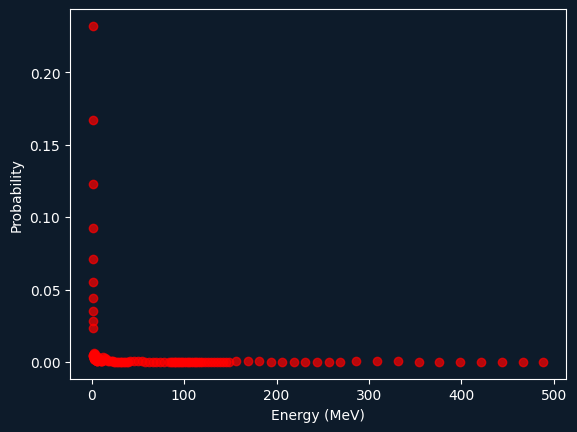

Created input_spectrum.txt with Grasshopper-compatible formatting


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
def apply_dark_blue_theme():
    plt.rcParams.update({
        'figure.facecolor': '#0d1b2a',
        'axes.facecolor': '#0d1b2a',
        'axes.edgecolor': 'white',
        'axes.labelcolor': 'white',
        'xtick.color': 'white',
        'ytick.color': 'white',
        'text.color': 'white',
        'axes.titlecolor': 'white',
        'grid.color': 'gray',
        'grid.alpha': 0.3,
    })

GAMMA = 4 #2.5  # Spectral index
BINS_PER_BAND = 10  # Sub-divisions per energy channel

# Read cumulative fluence data
df = pd.read_csv(
    'cumulative_fluence_2020-2023.txt',
    sep='\t',
    names=['Energy Band', 'Fluence'],
    skiprows=1
)
df['Fluence'] = df['Fluence'].astype(float)

spectrum_data = []

def process_band(band, fluence):
    """Distribute fluence across sub-bins using power-law weighting"""
    e_start, e_end = map(float, band.split('-'))

    # Create sub-bins with proper energy spacing
    sub_bins = np.linspace(e_start, e_end, BINS_PER_BAND + 1)
    bin_widths = np.diff(sub_bins)
    midpoints = sub_bins[:-1] + bin_widths/2

    # Power-law weighting (E^-γ)
    weights = midpoints ** -GAMMA
    norm_weights = weights / weights.sum()

    # Distribute fluence
    for energy, weight in zip(midpoints, norm_weights):
        spectrum_data.append((energy, fluence * weight))

# Process all energy bands
for _, row in df.iterrows():
    process_band(row['Energy Band'], row['Fluence'])

# Create DataFrame and normalize probabilities
df_spectrum = pd.DataFrame(spectrum_data,
                          columns=['Energy (MeV)', 'Probability'])
total_fluence = df_spectrum['Probability'].sum()
df_spectrum['Probability'] = df_spectrum['Probability'] / total_fluence

# Format numbers without scientific notation
def format_float(value):
    """Convert float to string without scientific notation"""
    s = f"{value:.15f}"  # Format with 10 decimal places
    # Remove trailing zeros and potential . at end
    return s.rstrip('0').rstrip('.') if '.' in s else s

# Save Grasshopper-compatible spectrum
with open('input_spectrum.txt', 'w') as f:
    for energy, prob in df_spectrum.sort_values('Energy (MeV)').values:
        f.write(f"{format_float(energy)}\t{format_float(prob)}\n")

apply_dark_blue_theme()

plt.scatter(df_spectrum['Energy (MeV)'],df_spectrum['Probability'],
            color='red', alpha=0.7)
# plt.xscale('log')
# plt.title('')
plt.xlabel('Energy (MeV)')
plt.ylabel('Probability')
plt.show()

print("Created input_spectrum.txt with Grasshopper-compatible formatting")


3 years output

use the input_spectrum.txt and the number of protons to simulate in grasshopper(5 times with random seed to get 15 years output) merge all the output files and give to the code below

N_atoms: 8491033.267239477
E_dep_eV: 812017.8257380645
DPA: 0.0021251642767174733
delta_rho: 2.1251642767174733e-09
=== NRT Model Results (100×100×10 nm³ Cu) ===
DPA (NRT): 2.125e-03
Resistance change: 12.649787361413539%


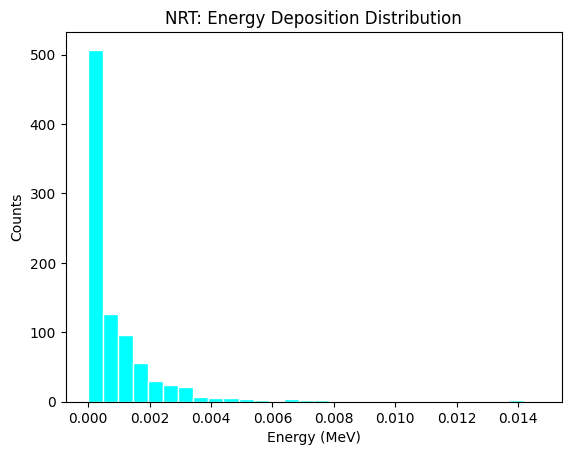

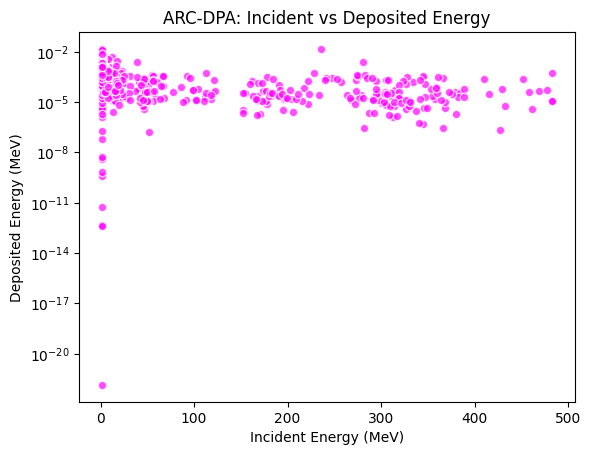

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def apply_white_theme():
    plt.rcParams.update({
        'figure.facecolor': 'white', 'axes.facecolor': 'white',
        'axes.edgecolor': 'black', 'axes.labelcolor': 'black',
        'xtick.color': 'black', 'ytick.color': 'black',
        'text.color': 'black', 'axes.titlecolor': 'black',
        'grid.color': 'gray', 'grid.alpha': 0.3,
    })
# def apply_dark_blue_theme():
#     plt.rcParams.update({
#         'figure.facecolor': '#0d1b2a',
#         'axes.facecolor': '#0d1b2a',
#         'axes.edgecolor': 'white',
#         'axes.labelcolor': 'white',
#         'xtick.color': 'white',
#         'ytick.color': 'white',
#         'text.color': 'white',
#         'axes.titlecolor': 'white',
#         'grid.color': 'gray',
#         'grid.alpha': 0.3,
#     })
# --- File Loading ---
df = pd.read_csv(
    '/content/out_100_10_3_s678910.dat',
    sep='\t',
    names=[
        'E_beam', 'E_incident', 'E_deposited', 'x_incident', 'y_incident',
        'z_incident', 'theta', 'Time', 'EventID', 'TrackID', 'ParticleID',
        'ParticleName', 'CreatorProcessName', 'IsEdepositedTotalEntry',
        'IsSurfaceHitTrack', 'detector#'
    ],
    skiprows=1
)

# --- Data Filtering ---
df_cu = df[(df['detector#'] == 0) & (df['E_deposited'] > 0) & (df['E_incident'] > 0) & (df['ParticleName'] == 'proton')]
# print(df_cu)
# --- Physics Constants (NRT) ---
rho_0 = 1.68e-8  # Cu resistivity [Ω·m] (NIST SRD 126)
eta = 0.8         # NRT efficiency factor
E_d = 18.0        # Displacement threshold 30[eV] (ASTM E521-16) worst case 18
alpha = 1e-6    # Δρ/DPA [Ω·m/DPA] (JPS Conf. Proc. 33)

# --- Geometry ---
L = 100e-9  # Length [m]
W = 100e-9  # Width [m]
T = 10e-9   # Thickness [m]
A = W * T   # Cross-section [m²]
V = L * A   # Volume [m³]

# Atomic density
rho_Cu = 8960         # Density [kg/m³]
M_Cu = 0.063546       # Molar mass [kg/mol]
N_atoms = (rho_Cu * V / M_Cu) * 6.022e23  # Atoms in volume
print(f"N_atoms: {N_atoms}")
# --- NRT Damage Calculation ---
E_dep_eV = (df_cu['E_deposited']).sum() * 1e6  # MeV→eV
print(f"E_dep_eV: {E_dep_eV}")
DPA = (0.8 * E_dep_eV) / (2 * E_d * N_atoms)  # NRT formula
print(f"DPA: {DPA}")
delta_rho = alpha * DPA  # Resistivity change
print(f"delta_rho: {delta_rho}")
# --- Resistance Change ---
R0 = rho_0 * L / A
R_new = (rho_0 + delta_rho) * L / A
delta_R_pct = ((R_new - R0)/R0) * 100

# --- Output ---
print("=== NRT Model Results (100×100×10 nm³ Cu) ===")
print(f"DPA (NRT): {DPA:.3e}")
print(f"Resistance change: {delta_R_pct}%")

# --- Visualization ---
apply_white_theme()
plt.hist(df_cu['E_deposited'], bins=30, color='cyan', edgecolor='white')
plt.title('NRT: Energy Deposition Distribution')
plt.xlabel('Energy (MeV)')
plt.ylabel('Counts')
plt.show()
plt.scatter(df_cu['E_beam'], df_cu['E_deposited'],
            color='magenta', alpha=0.7, edgecolor='white')
plt.yscale('log')
plt.title('ARC-DPA: Incident vs Deposited Energy')
plt.xlabel('Incident Energy (MeV)')
plt.ylabel('Deposited Energy (MeV)')
plt.show()
